# Taxi Trips and Traffic

#### Mike Alvarino maa2282, Colby Wise cjw2165

Recently, New York City released a dataset consisting of several million yellow taxi trips throughout its boroughs and into New Jersey. Where most models use real-time data from users to predict arrival times at the present moment, we believe they could be improved by including a predictive element. Our intent is to use the NYC Taxi and Limousine Commission's yellow and green cab data set to estimate travel time between pickup and dropoffs at any given place and time.

Throughout our presentation we will be using the example of a traveller visiting New York. Our hypothetical traveller is very popular and has many trips to make over the course of his day, and therefore wants the most accurate trip duration estimates possible.

In [1]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# our functions
import setup
import data
import visualizations
import basis_functions
pd.set_option('float_format', '{:f}'.format)
setup.set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

## Data

The [2015 NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml), consists of pickup and dropoff coordinates for trips, along with metadata like cost, distance, and number of passengers. Columns we expect to find especially useful are those that could affect the time to destination and, obviously, are not known in advance of the trip.

Since our dataset was tremendous (2 million trips) we needed to segment the data by borough and neighborhood to test different forms of inference. We downloaded a shapefile from [NYC Planning](http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page) and added the neighborhoods of both pickup and dropoff to the dataset. This was a costly process which we then found had already been done and was available online, remember to always google first.

Throughout the project we will use the example of an unfamiliar traveler, new to the New York City, trying to plan their next day. Such a traveller would need to know, for example, how long will it take to visit my friend at Columbia University at noon tomorrow?

#### Overview of Data
Total Samples: 1,760,396  
Date Range: 1/1/2016 - 07/01/2016  
Excluded to Manhattan  

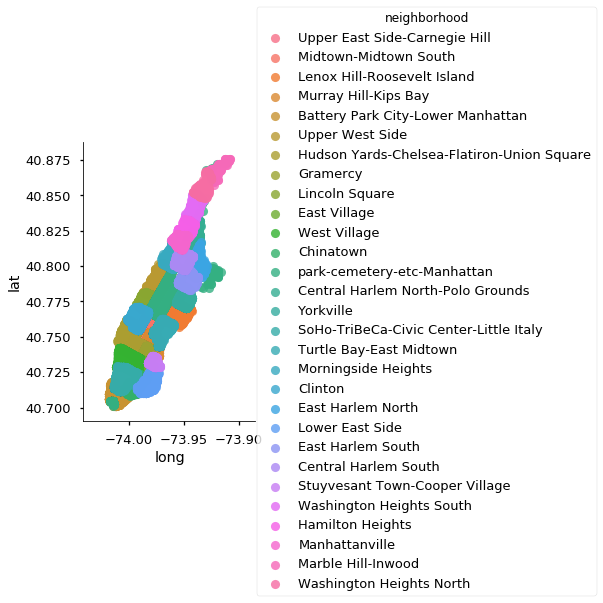

In [4]:
manhattan = data.get_borough_data("data/preprocessed.csv", "Manhattan")
rand_indices = np.random.choice(manhattan.shape[0], size=int(0.1 * manhattan.shape[0]), replace=False)
visualizations.visualize_by_borough(manhattan.iloc[rand_indices, :])
plt.show()

### Splitting Into Training And Test

Train Size: $\%80$  
Test Size: $\%20$  

#### Limiting Columns
We limit our data set $x$ to the following columns:   
1. pickup_latitude  
1. pickup_longitude
1. dropoff_latitude
1. dropoff_longitude
1. manhattan_distance
1. pickup_hour
1. pickup_timestamp

And limit $y$ to the following:
1. trip_duration

#### Standardization
Note that we are standardizing our data so all $x \sim N(0, 1)$ and limit 

In [1]:
ues_to_msh = data.get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)
indicator_cols = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "manhattan_distance", "pickup_hour", "pickup_timestamp"]
y_cols = ["trip_duration"]
x_train_raw, y_train_raw, x_test_raw, y_test_raw = data.train_test_split(ues_to_msh, 0.2, indicator_cols, y_cols)

x_train = data.standardize_cols(x_train_raw)
x_test = data.standardize_cols(x_test_raw)
vis = x_train_raw.copy(deep=True)
vis["trip_duration"] = y_train_raw.copy(deep=True)

NameError: name 'data' is not defined

# Model

The General Linear Model is a good baseline for regression models and a good starting point for the Gaussian Process we will be working towards. The model can be framed as the following:


$$f(x) = x^Tw$$
$$y = f(x) + \epsilon$$


where x ins the input vector, w is a vector of weights, $y$ is the prediction, where


$$\epsilon \sim N(0, \sigma^2_n)$$

In [9]:
N, D = x_train.shape
X = tf.placeholder(tf.float32, [N, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=[0.0], scale=1.0)
alpha = ed.models.Normal(loc=[0.0], scale=1.0)

Y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=alpha)

# Inference

Here we use KLqp inference almost exactly as it is used in the GLM example, except we also allow our y scale to vary. We solve this using KLqp rather than the closed form solution for the simple reason that finding the inverse of our matrix over our dataset is not feasible.

# TODO: Add explanation of why we use KLqp, maybe Metropolis Hastings

In [10]:
qalpha = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([1])),
                                                   tf.Variable(tf.zeros([1]))),
    bijector=tf.contrib.distributions.bijectors.Exp())

qw = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D])),
                                       scale=tf.Variable(tf.random_normal([D])))

qb = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference = ed.KLqp({w: qw, b: qb, alpha: qalpha},
                    data={X: x_train.as_matrix(),
                          Y: y_train_raw.as_matrix().reshape(y_train_raw.shape[0])})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 2259.527


# Critique



In [14]:
N, D = x_test.shape
X_eval = tf.placeholder(tf.float32, [N, D])
y_posterior_predictive = ed.models.Normal(loc=ed.dot(X_eval, qw) + qb, scale=qalpha)
print(ed.evaluate("mean_absolute_error",
            data={X_eval: x_test.as_matrix(),
                  y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))},
             output_key=y_posterior_predictive))

9.22896


Back to our example of a visiting traveller, we can easily see that a 9 minute average error is inadequate. Over the course

The graph below is a prediction of our data solely as a function of pickup hour, meaning that all other points are held to their mean values as expected by the linear model, i.e. 0. We see that the predictions are reasonable. 

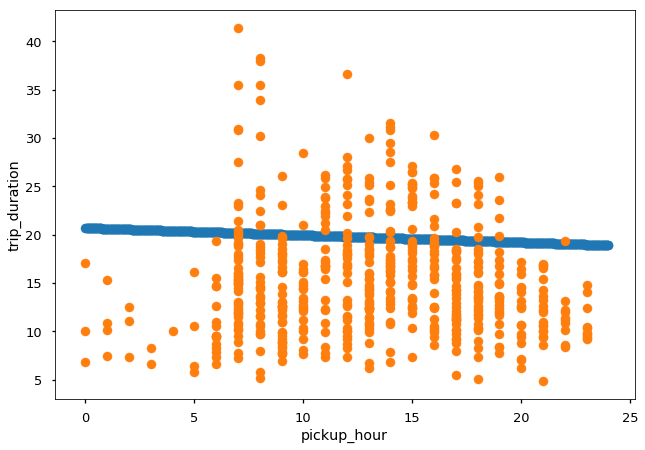

In [13]:
def vis_glm(num_pnts, indicator_cols, actual_data, qw, qb, qalpha):
    times = np.linspace(0, 24, num_pnts)
    x_vis = pd.DataFrame({i: [0.0] * num_pnts for i in indicator_cols})
    x_vis["pickup_hour"] = times
    x_vis["pickup_timestamp"] = x_vis["pickup_hour"].apply(lambda x: pd.to_datetime(x, unit="s").hour)
    x_vis_stndzd = data.standardize_cols(x_vis).fillna(0.0)
    qw_i = qw.sample().eval()
    qb_i = qb.sample().eval()
    qalpha_i = qalpha.sample().eval()
    line = np.matmul(x_vis_stndzd, qw_i) + qb_i + qalpha_i
    plt.scatter(x=times, y=line)
    plt.scatter(x=actual_data["pickup_hour"], y=actual_data["trip_duration"])
    plt.xlabel("Pickup Hour")
    plt.ylabel("Trip Duration")
    plt.show()

vis_glm(1000, indicator_cols, vis, qw, qb, qalpha)

# TODO: Dig into individual points around 1 - 3 am and explain that they are contributing most of the error
Now we need to quantify this estimator. The simplest form to use is a point estimate. We will use the mean absolute error for its easy interpretability.

An error of 9 minutes on a 20 minute trip is unreasonable, we will have to return to our model.